# Auxtel Spectra analysis : prediction transmission with gain and PTC

- Author : Sylvie Dagoret-Campagne
- creation date : 2023-12-12
- last update : 2023-12-12
- - last update : 2023-12-18
- affiliation : IJCLab/IN2P3/CNRS

After a notebook from Jeremy Neveu

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from spectractor.tools import from_lambda_to_colormap, wavelength_to_rgb
%matplotlib widget 
import h5py

In [2]:
import spectractor
from spectractor.simulation.throughput import load_transmission,plot_transmission_simple,TelescopeTransmission
from spectractor import parameters
from spectractor.extractor import dispersers
from spectractor.config import load_config,set_logger
import os

In [3]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'
plt.rcParams['legend.fontsize']=  12
plt.rcParams['font.size'] = 12

In [4]:
#from lsst.summit.utils.utils import checkStackSetup
#checkStackSetup()

In [5]:
import lsst.daf.butler as dafButler

repo = "/repo/main"
repo = "/repo/embargo"
# repo = "LATISS"
butler = dafButler.Butler(repo)
registry = butler.registry

for c in sorted(registry.queryCollections()):
    #if "u/jneveu" in c and "auxtel_atmo" in c:
    #if "u/dagoret" in c:
    if "u/dagoret" in c and "auxtel_atmo_202301_v3.0.3" in c:
        print(c)

u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208/20231208T215202Z
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208
u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208/20231208T211104Z


## Fitted param files

In [6]:
fitted_paramfile = "fitted_atmparamfile.hdf5"

## Smooth

In [7]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

## Config

### Config collection

In [8]:
my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsPTC_rebin2_231208"
#my_collection = "u/dagoret/auxtel_atmo_202301_v3.0.3_doGainsNOPTC_rebin2_231208"

### Config Auxtel

In [9]:
#config_path = "~/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
#config_path = "/home/d/dagoret/repos/repos_w_2023_44/Spectractor/config/auxtel.ini"
config_fullpath = os.path.join(spectractor.__path__[0],"../config/auxtel.ini")
throughput_filename="multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt"

In [10]:
load_config(config_fullpath)

### Config Telescope Throughtput

In [11]:
throughput_fullpath = os.path.join(spectractor.__path__[0],parameters.THROUGHPUT_DIR)
throughput_fullfilename = os.path.join(throughput_fullpath,throughput_filename)

In [12]:
tel_lambdas, tel_thr, tel_errthr = load_transmission(throughput_fullfilename) 

In [13]:
parameters.THROUGHPUT_DIR = throughput_fullpath 
parameters.OBS_FULL_INSTRUMENT_TRANSMISSON = throughput_filename
print(parameters.THROUGHPUT_DIR )
print(parameters.OBS_FULL_INSTRUMENT_TRANSMISSON)

/home/d/dagoret/repos/repos_w_2023_44/Spectractor/lib/python/spectractor/simulation/AuxTelThroughput/
multispectra_holo4_003_HD142331_20230802_AuxTel_doGainsPTC_v3.0.3_throughput.txt


In [14]:
%matplotlib inline
tel = TelescopeTransmission()
tel.plot_transmission()

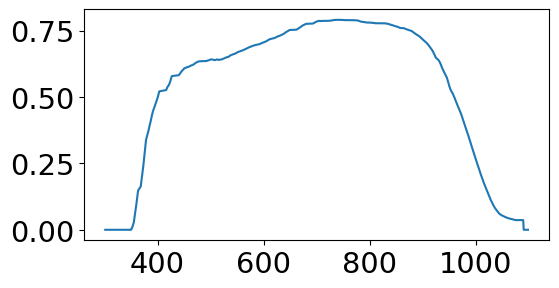

In [15]:
%matplotlib inline
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot()
ax.plot(tel_lambdas,tel.transmission(tel_lambdas))

### Config disperser

In [16]:
disp = dispersers.Hologram("holo4_003")

## Load config filename for Auxtel

In [17]:
load_config(config_fullpath)

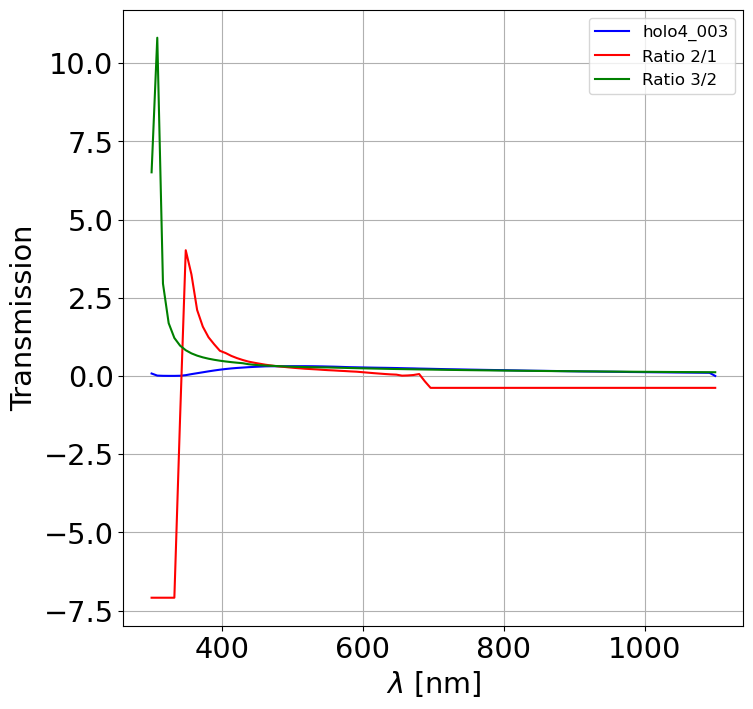

In [18]:
disp.plot_transmission()

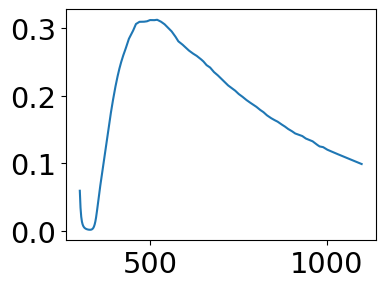

In [19]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot()
ax.plot(tel_lambdas,disp.transmission(tel_lambdas))

## Check the presence of the spectra

### select the date of observation

In [20]:
#DATEOBS = 20231207 # studied 2023/12/12
#DATEOBS = 20231206 # studied 2023/12/18
#DATEOBS = 20231205 # studied 2023/12/18
#DATEOBS = 20231204 # studied 2023/12/18
#DATEOBS = 20231130 # studied 2023/12/18
#DATEOBS = 20231129 # studied 2023/12/18
#DATEOBS = 20231128 # studied 2023/12/18
DATEOBS = 20231127 # studied 2023/12/18

In [21]:
where = f"instrument='LATISS' and visit.day_obs={DATEOBS}" 
#where = "instrument='LATISS' "
records = list(butler.registry.queryDimensionRecords('visit', datasets='spectractorSpectrum', where=where,  collections=my_collection))
# records = list(butler.registry.queryDimensionRecords('visit', datasets='raw', where=where))

In [22]:
print(">>> Number of records : ",len(records))
records[-1]

>>> Number of records :  35


visit.RecordClass(instrument='LATISS', id=2023112700404, physical_filter='empty~holo4_003', name='AT_O_20231127_000404', day_obs=20231127, seq_num=404, exposure_time=60.0, target_name='HD185975', observation_reason='object', science_program='spec-survey', azimuth=180.4215296729543, zenith_angle=62.31125980331413, region=ConvexPolygon([UnitVector3d(0.026977020273701652, -0.03373028272410157, -0.9990668187886657), UnitVector3d(0.028055824405020625, -0.0355542304879863, -0.9989738572211796), UnitVector3d(0.026259129182147768, -0.03661744755764324, -0.9989842945056536), UnitVector3d(0.025180325136862528, -0.03479349972734485, -0.9990772560731853)]), timespan=Timespan(begin=astropy.time.Time('2023-11-28 08:21:31.155995', scale='tai', format='iso'), end=astropy.time.Time('2023-11-28 08:22:31.396000', scale='tai', format='iso')))

### List first of first records

In [23]:
first_seqnum = []

for i, r in enumerate(records):

    print(f"============= ({i}) ============datasetType = spectraction ============================================")
    print("fullId..................:",r.id)
    print("day_obs..................:",r.day_obs)
    print("target..................:",r.target_name)
    print("filt+disp..................:",r.physical_filter)
    seqnum = r.id-r.day_obs*100000
    print("seqnum ....................:",seqnum)
    first_seqnum.append(seqnum)

    # spec = butler.get('spectractorSpectrum', visit=r.id, detector=0, collections=my_collection, instrument='LATISS')
    
    if i>5:
        break

============= (0) ============datasetType = spectraction ============================================
fullId..................: 2023112700067
day_obs..................: 20231127
target..................: HD205905
filt+disp..................: empty~holo4_003
seqnum ....................: 67
============= (1) ============datasetType = spectraction ============================================
fullId..................: 2023112700073
day_obs..................: 20231127
target..................: HD185975
filt+disp..................: empty~holo4_003
seqnum ....................: 73
============= (2) ============datasetType = spectraction ============================================
fullId..................: 2023112700074
day_obs..................: 20231127
target..................: HD185975
filt+disp..................: empty~holo4_003
seqnum ....................: 74
============= (3) ============datasetType = spectraction ============================================
fullId..................: 20

In [24]:
# delete a collection
# butler.pruneDatasets(datasetRefs, disassociate=True, unstore=True, purge=True)

## Load one spectrum

In [25]:
sel_seqnum = first_seqnum[-3] 

In [26]:
dataId = {"day_obs": DATEOBS, "seq_num": sel_seqnum, 'instrument':'LATISS',"detector": 0}
spec= butler.get('spectractorSpectrum',dataId,collections=my_collection)
p = butler.get('spectrumLibradtranFitParameters',dataId,collections=my_collection)
p

************ getObsAtmo imported ************* 
/home/d/dagoret/.local/lib/python3.11/site-packages/getObsAtmo
>>>> _getPackageDir /home/d/dagoret/.local/lib/python3.11/site-packages/getObsAtmo
>>>> getObsSiteDataFrame      altitude   pressure
LSST    2.663  731.50433
CTIO    2.207   774.6052
OHP      0.65  937.22595
PDM    2.8905  710.90637
OMK     4.205  600.17224
OSL       0.0     1013.0


2023-12-18 14:25:14  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


FitParameters(values=array([ 1.84387367e+00,  0.00000000e+00,  5.00000925e-02,  1.20000625e+00,
        4.00018333e+02,  5.00002155e+00,  1.00002591e+00,  1.84957567e+02,
       -2.00000000e+00,  0.00000000e+00]), labels=['A1', 'A2', 'VAOD', 'angstrom_exp', 'ozone [db]', 'PWV [mm]', 'reso [pix]', 'D_CCD [mm]', 'alpha_pix [pix]', 'B'], axis_names=['$A_1$', '$A_2$', 'VAOD', '$\\"a$', 'ozone [db]', 'PWV [mm]', 'reso [pix]', '$D_{CCD}$ [mm]', '$\\alpha_{\\mathrm{pix}}$ [pix]', '$B$'], bounds=[[0, 2], [0, 20.0], [0, 0.1], [0, 3], [0.0, 600.0], [0.0, 10.0], [0.1, 10], [182.95756337654802, 186.95756337654802], [-2, 2], [-inf, inf]], fixed=[False, True, False, False, False, False, False, False, True, True], truth=None, filename='', extra=None)

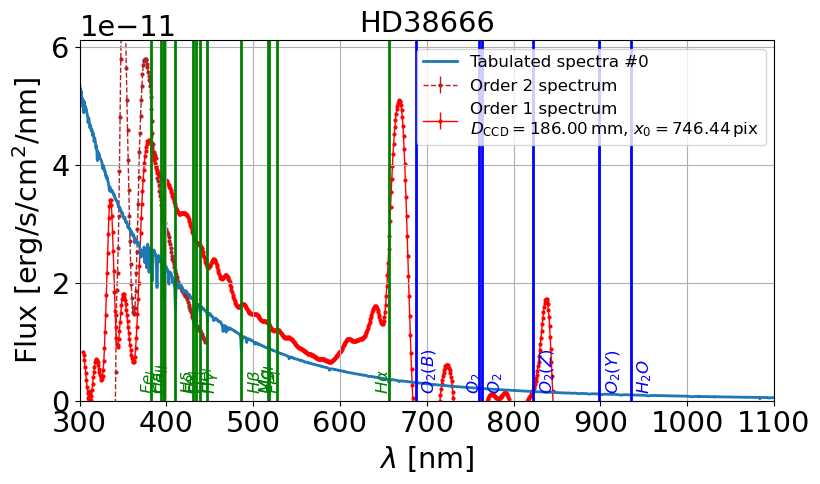

In [27]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot()
_ = spec.plot_spectrum(force_lines=True,ax=ax)

## Load all 1D spectrum and fitted atmospheric parameters

Three kind of informations:
 - 1D Spectrum : ``spectractorSpectrum``
 - atmospheric parameters fitted on 1D spectrum ``spectrumLibradtranFitParameters``
 - atmospheric parameters fitted on Spectrogram ``spectrogramLibradtranFitParameters``

In [28]:
params_spectrum = []
params_spectrogram = []
times = []
headers = []
spectra = []

for i, r in enumerate(records):
    try:
        times.append(r.day_obs)
        spec =  butler.get('spectractorSpectrum', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        headers.append(spec.header)
        spectra.append(spec)
        p = butler.get('spectrumLibradtranFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        params_spectrum.append(p)
        p = butler.get('spectrogramLibradtranFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        params_spectrogram.append(p)
    #except ValueError:
    except Exception as inst:
        except_type = type(inst)
        except_args = inst.args
        print("catch exception ", inst, "type =",except_type, "args = ",except_args) 
        print("\t >>>>> Skip record ", r.id)
        continue

2023-12-18 14:25:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:15  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:16  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:17  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:18  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:19  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:20  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:21  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:22  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:23  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


In [29]:
len(params_spectrogram)

35

## Filtering data

In [30]:
def select_files(collection, where):
    """
    Select all records according the where clause
    """
    # datasetRefs = registry.queryDatasets(datasetType='spectractorSpectrum', collections=my_collection, where=where)
    #records = list(butler.registry.queryDimensionRecords('exposure', where=where))
    records = list(butler.registry.queryDimensionRecords('exposure', datasets='spectractorSpectrum', where=where,  collections=collection))
    records = sorted(records, key=lambda x: x.id, reverse=False)
    return records

def filter_data(records, sigma_clip=3):  # pragma: no cover
    """
    Spectrum reconstruction Quality Selection
    """
    from scipy.stats import median_abs_deviation
    D = []
    chi2 = []
    dx = []
    amplitude = []
    regs = []
    times = []
    specs = []
    alpha_0_2 = []
    #parameters.VERBOSE = False
    #parameters.DEBUG = False
    for i, r in enumerate(records):
        times.append(r.day_obs)
        spec = butler.get('spectractorSpectrum', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        spec.dataId = r.id
        if spec.x0[0] > 500: 
            continue
        D.append(spec.header["D2CCD"])
        dx.append(spec.header["PIXSHIFT"])
        regs.append(np.log10(spec.header["PSF_REG"]))
        amplitude.append(np.sum(np.abs(spec.data[300:])))
        # if "CHI2_FIT" in header:
        chi2.append(spec.header["CHI2_FIT"])
        specs.append(spec)
        p = butler.get('spectrumForwardModelFitParameters', visit=r.id, collections=my_collection, detector=0, instrument='LATISS')
        alpha_0_2.append(p.values[p.get_index("alpha_0_2")])
        #except:
        #    new_file_names.remove(name)
        #    print(f"fail to open {name}. len(file_names)={len(new_file_names)}")
    params = {'D2CCD': np.array(D),
              'dx': np.array(dx),
              'regs': np.array(regs),
              'chi2': np.array(chi2),
              'amplitude': np.array(amplitude),
              'alpha_0_2': np.array(alpha_0_2)
             }
    k = np.arange(len(D))
    filter_indices = np.ones_like(k, dtype=bool)
    for par in params.keys():
        if par in ['amplitude']: #, 'alpha_0_2']:
            continue
        filter_indices *= np.logical_and(params[par] > np.median(params[par]) - sigma_clip * median_abs_deviation(params[par]),
                                         params[par] < np.median(params[par]) + sigma_clip * median_abs_deviation(params[par]))
    for par in params.keys():
        fig = plt.figure(figsize=(8,4))
        plt.plot(k, params[par])
        plt.plot(k[filter_indices], params[par][filter_indices], "ko")
        plt.grid()
        plt.title(par)

        suptitle = f"Observations : {DATEOBS} \n collection = {my_collection}"
        plt.suptitle(suptitle,fontsize=10,y=1.00)
        plt.show()
    return [s for i,s in enumerate(specs) if filter_indices[i]]


def plot_spectra(spectra, colorparams):
    """
    plot spectra
    """

    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    colormap = cm.Reds
    #colormap = cm.jet 

    normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

    all_target_names = [] 

    fig  = plt.figure(figsize=(11,6))
    for spec in spectra:
        target_name = spec.target.label
        if target_name in all_target_names:
            plt.plot(spec.lambdas, spec.data, color = colormap(normalize(spec.airmass)))
        else:
            plt.plot(spec.lambdas, spec.data, color = colormap(normalize(spec.airmass)),label=target_name)
            all_target_names.append(target_name)
            
    plt.grid()
    plt.xlabel("$\lambda$ [nm]")
    plt.ylabel(f"Flux [{spec.units}]")
    plt.legend()
    
    # Colorbar setup
    s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
    s_map.set_array(colorparams)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (colorparams[1] - colorparams[0])/2.0
    boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

    # Use this to emphasize the discrete color values
    cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer

    # Use this to show a continuous colorbar
    #cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, format='%2i')
    cbar.set_label("Airmass $z$")
    title = f"Observations : {DATEOBS}"
    suptitle = f"collection = {my_collection}"
    plt.title(title)
    plt.suptitle(suptitle,fontsize=10)
    plt.show()
    return fig



2023-12-18 14:25:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:24  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:25  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:26  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:27  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:28  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:29  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:30  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


2023-12-18 14:25:31  Spectrum   load_spectrum_latest WARNING 
	Failed to set spectrum attribute humidity using header OUTHUM


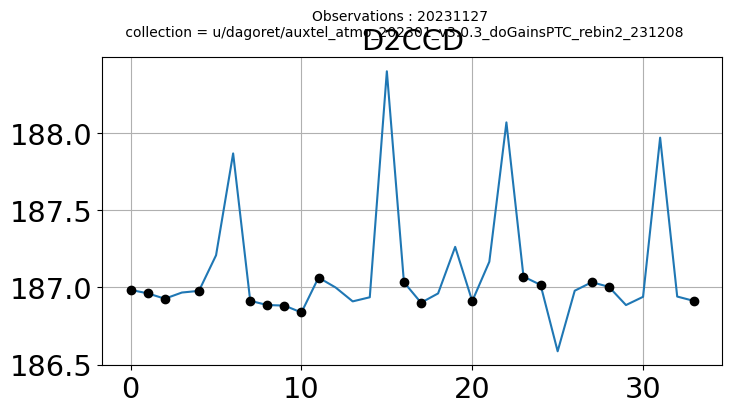

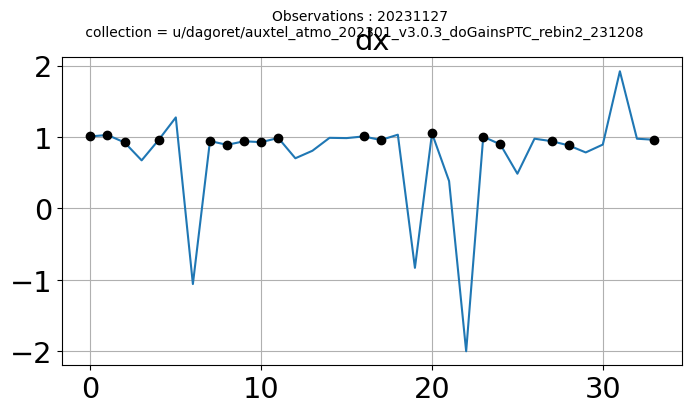

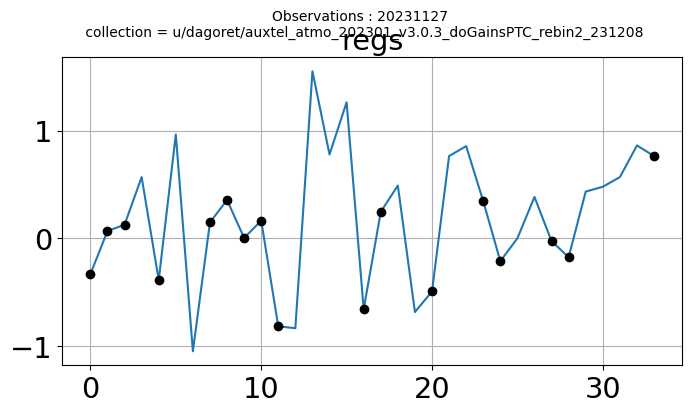

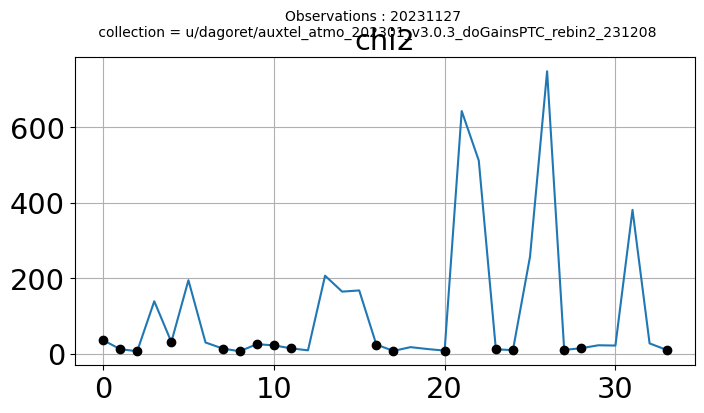

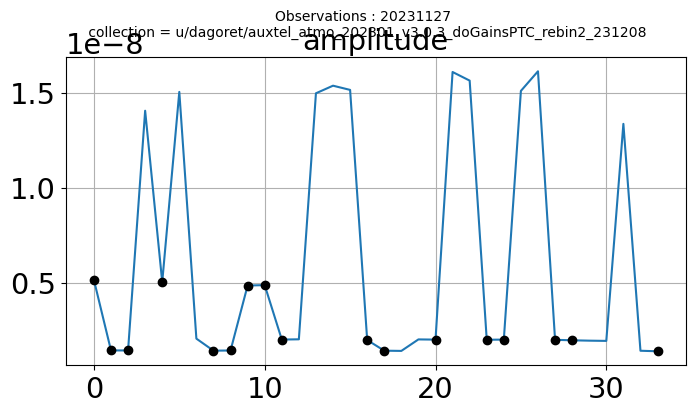

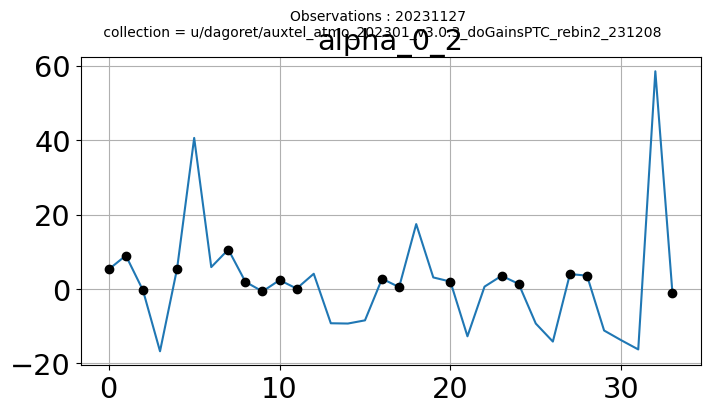

In [31]:
spectra_filtered = filter_data(records)

/tmp/ipykernel_7381/2290022125.py:108: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer


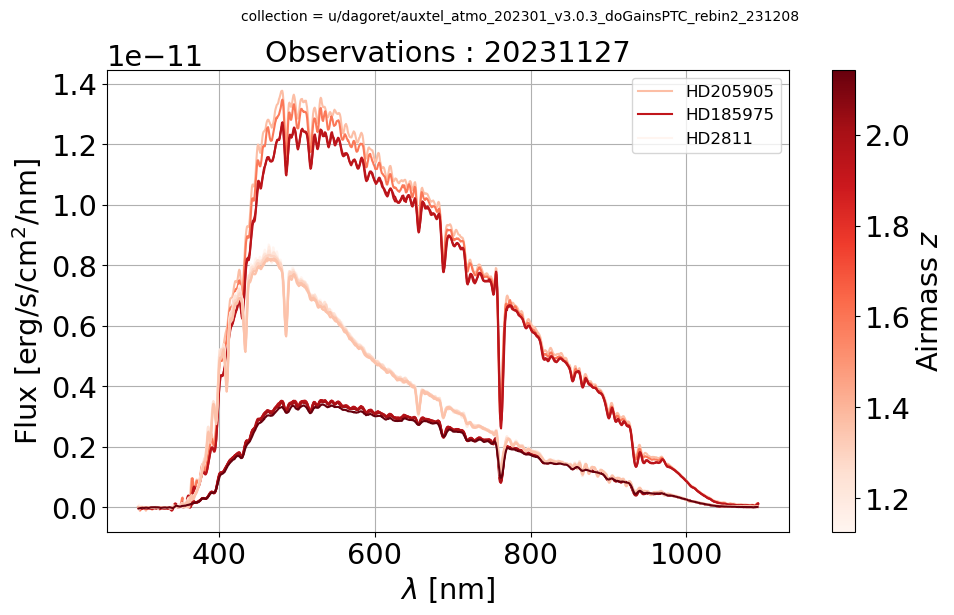

In [32]:
fig = plot_spectra(spectra_filtered, [spec.airmass for spec in spectra_filtered])

In [33]:
list_of_targets = np.unique([spec.target.label for spec in spectra_filtered])
print(">>> List of targets ",list_of_targets)

>>> List of targets  ['HD185975' 'HD205905' 'HD2811']


In [34]:
import getCalspec.getCalspec as gcal

In [35]:
all_calspecs = {}
for target_name in list_of_targets:
    c =  gcal.Calspec(target_name) 
    all_calspecs[target_name] = c.get_spectrum_numpy() 

In [36]:
all_calspecs["HD185975"].keys()

dict_keys(['WAVELENGTH', 'FLUX', 'STATERROR', 'SYSERROR'])

In [37]:
all_calspecs.keys()

dict_keys(['HD185975', 'HD205905', 'HD2811'])

(3000.0, 10000.0)

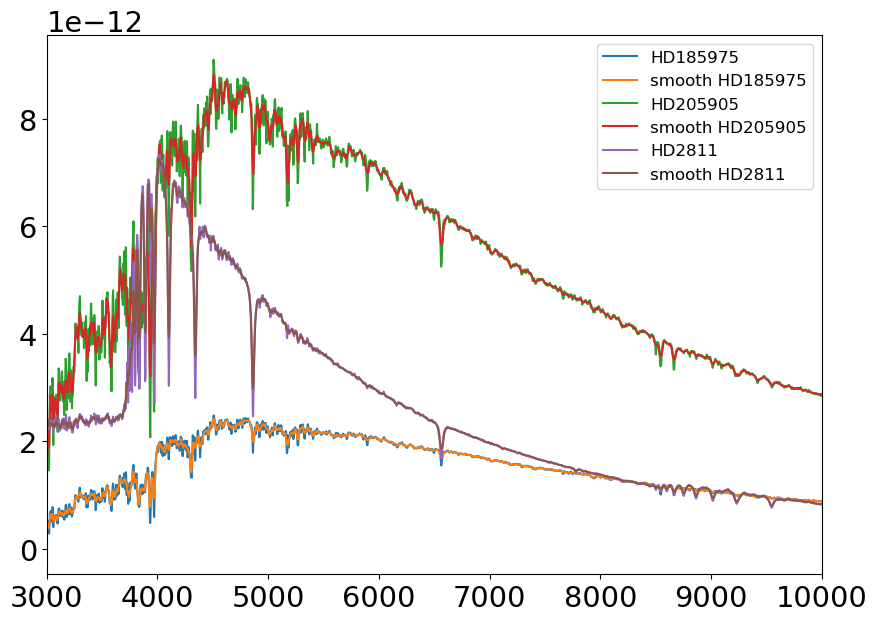

In [38]:
all_calspecs_sm = {}
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()
span = 3
for target_name in list_of_targets:
    c_dict = all_calspecs[target_name]
    wls = c_dict["WAVELENGTH"].value
    sed = c_dict["FLUX"].value
    ax.plot(wls,sed,label=target_name)
    
    sedm = smooth_data_np_convolve(sed,span)
    c_dict_sm = {"WAVELENGTH":wls,"FLUX":sedm}
    all_calspecs_sm[target_name] = c_dict_sm
    ax.plot(wls,sedm,label="smooth " +target_name)
ax.legend()
ax.set_xlim(3000.,10000.)    

In [39]:
c_dict["WAVELENGTH"].value

array([  1140.1373291,   1140.720947 ,   1141.304565 , ...,
       318350.       , 318625.       , 318899.       ])

## Plot ratio

In [40]:
def plot_atmtransmission(spectra, colorparams):
    """
    plot spectra
    """

    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    colormap = cm.Reds
    #colormap = cm.jet 
   

    normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

    all_shown_target_names = [] 
    
    fig  = plt.figure(figsize=(11,6))
    for spec in spectra:
        
        
        target_name = spec.target.label

        wls = spec.lambdas
        flx = spec.data
        flx_err = spec.err
        
        #c_dict = all_calspecs[target_name]
        c_dict = all_calspecs_sm[target_name]

        #smooth_data_np_convolve(sed,span)
        
        sed=np.interp(wls, c_dict["WAVELENGTH"]/10.,c_dict["FLUX"]*10.,left=1e-15,right=1e-15)
       
                     
        ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
       
        indexes = np.where(np.logical_and(wls>350.,wls<=1000.))[0]
       
        sel_wls = wls[indexes]
        sel_ratio = ratio[indexes]
        
        if target_name in all_shown_target_names:
            plt.plot(sel_wls, sel_ratio, color = colormap(normalize(spec.airmass)))
        else:
            plt.plot(sel_wls,sel_ratio, color = colormap(normalize(spec.airmass)),label=target_name)
            all_shown_target_names.append(target_name)
            
     
            
    plt.grid()
    plt.xlabel("$\lambda$ [nm]")
    #plt.ylabel(f"Flux [{spec.units}]")
    plt.legend()
    plt.xlim(360.,1000.)  
    plt.ylim(0.,1.2)  
    
    # Colorbar setup
    s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
    s_map.set_array(colorparams)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (colorparams[1] - colorparams[0])/2.0
    boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

    # Use this to emphasize the discrete color values
    cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer

    # Use this to show a continuous colorbar
    #cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, format='%2i')
    cbar.set_label("Airmass $z$")
    title = f"Atmospheric transmission at target airmasses)"
    suptitle = f"obs : {DATEOBS} \n coll = {my_collection}"
    plt.title(title)
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.show()
    



In [41]:
def plot_atmtransmission_zcorr(spectra, colorparams):
    """
    plot spectra
    """

    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    colormap = cm.Reds
    #colormap = cm.jet 
   

    normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

    all_shown_target_names = [] 
    
    fig  = plt.figure(figsize=(11,6))
    for spec in spectra:
        
        
        target_name = spec.target.label

        wls = spec.lambdas
        flx = spec.data
        flx_err = spec.err
        
        #c_dict = all_calspecs[target_name]
        c_dict = all_calspecs_sm[target_name]

        #smooth_data_np_convolve(sed,span)
        
        sed=np.interp(wls, c_dict["WAVELENGTH"]/10.,c_dict["FLUX"]*10.,left=1e-15,right=1e-15)
       
                     
        ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
       
        indexes = np.where(np.logical_and(wls>350.,wls<=1000.))[0]
       
        sel_wls = wls[indexes]
        sel_ratio = ratio[indexes]
        sel_ratio_airmas_corr = np.power(sel_ratio,1/spec.airmass)
        
        if target_name in all_shown_target_names:
            plt.plot(sel_wls, sel_ratio_airmas_corr, color = colormap(normalize(spec.airmass)))
        else:
            plt.plot(sel_wls,sel_ratio_airmas_corr, color = colormap(normalize(spec.airmass)),label=target_name)
            all_shown_target_names.append(target_name)
            
     
            
    plt.grid()
    plt.xlabel("$\lambda$ [nm]")
    #plt.ylabel(f"Flux [{spec.units}]")
    plt.legend()
    plt.xlim(360.,1000.)  
    plt.ylim(0.,1.2)  
    
    # Colorbar setup
    s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
    s_map.set_array(colorparams)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (colorparams[1] - colorparams[0])/2.0
    boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

    # Use this to emphasize the discrete color values
    cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer

    # Use this to show a continuous colorbar
    #cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, format='%2i')
    cbar.set_label("Airmass $z$")
    title = f"Atmospheric transmission scaled for airmass=1)"
    suptitle = f"obs : {DATEOBS} \n coll = {my_collection}"
    plt.title(title)
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.show()
    



/tmp/ipykernel_7381/2286372081.py:34: RuntimeWarning: divide by zero encountered in divide
  ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
/tmp/ipykernel_7381/2286372081.py:65: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer


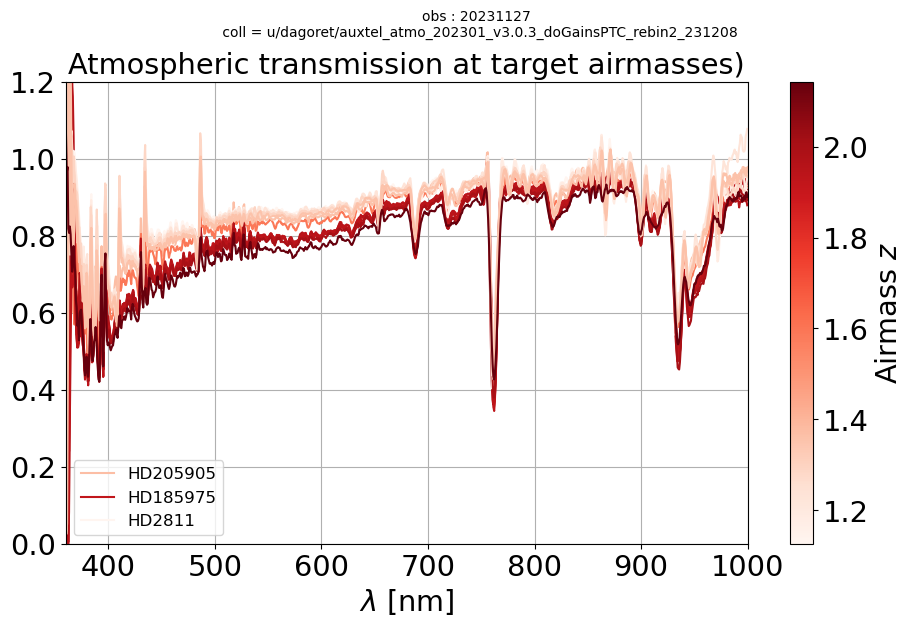

In [42]:
plot_atmtransmission(spectra_filtered, [spec.airmass for spec in spectra_filtered])

/tmp/ipykernel_7381/2552018270.py:34: RuntimeWarning: divide by zero encountered in divide
  ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
/tmp/ipykernel_7381/2552018270.py:40: RuntimeWarning: invalid value encountered in power
  sel_ratio_airmas_corr = np.power(sel_ratio,1/spec.airmass)
/tmp/ipykernel_7381/2552018270.py:66: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer


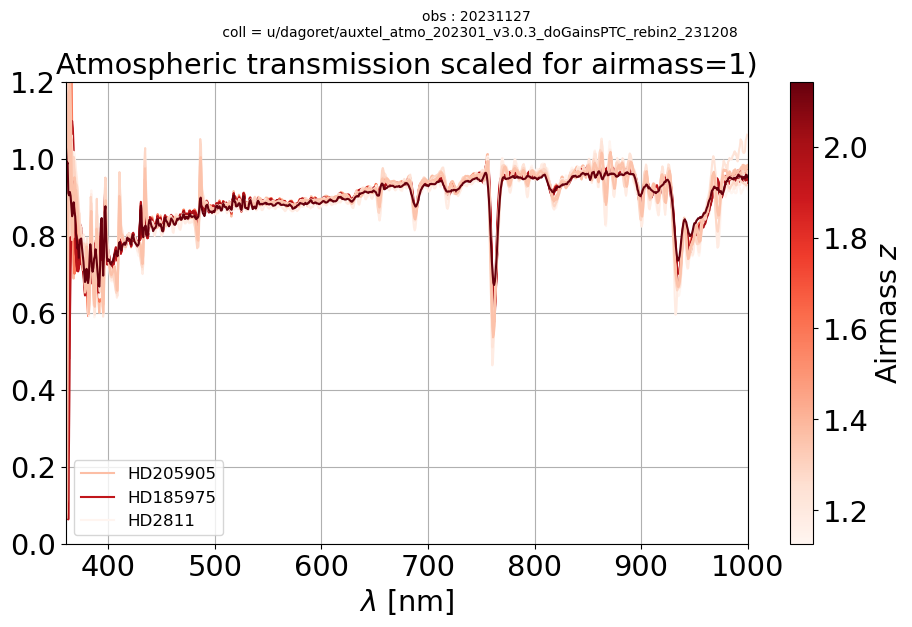

In [43]:
plot_atmtransmission_zcorr(spectra_filtered, [spec.airmass for spec in spectra_filtered])

## Atmospheric simulation

In [44]:
from getObsAtmo.getObsAtmo import ObsAtmo


In [45]:
def plot_atmtransmission_zcorr_antatmsim(spectra, colorparams,am=1,pwv=2,oz=300,vaod=0.01,grey=0.1):
    """
    plot spectra
    """

    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    colormap = cm.Reds
    #colormap = cm.jet 
   

    normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

    all_shown_target_names = [] 
    
    fig  = plt.figure(figsize=(11,6))
    for spec in spectra:
        
        
        target_name = spec.target.label

        wls = spec.lambdas
        flx = spec.data
        flx_err = spec.err
        
        #c_dict = all_calspecs[target_name]
        c_dict = all_calspecs_sm[target_name]

        #smooth_data_np_convolve(sed,span)
        
        sed=np.interp(wls, c_dict["WAVELENGTH"]/10.,c_dict["FLUX"]*10.,left=1e-15,right=1e-15)
       
                     
        ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
       
        indexes = np.where(np.logical_and(wls>350.,wls<=1000.))[0]
       
        sel_wls = wls[indexes]
        sel_ratio = ratio[indexes]
        sel_ratio_airmas_corr = np.power(sel_ratio,am/spec.airmass)/(np.power(grey,am))
        
        if target_name in all_shown_target_names:
            plt.plot(sel_wls, sel_ratio_airmas_corr, color = colormap(normalize(spec.airmass)))
        else:
            plt.plot(sel_wls,sel_ratio_airmas_corr, color = colormap(normalize(spec.airmass)),label=target_name)
            all_shown_target_names.append(target_name)

    
    textstr = '\n'.join((
    r'$am=%.2f$' % (am, ),
    r'$pwv=%.2f$ mm' % (pwv, ),
    r'$ozone=%.1f$ DU' % (oz, ),
    r'$vaod=%.3f$' % (vaod,)))
    emul1 =  ObsAtmo("AUXTEL",740.)
    emul2 =  ObsAtmo("AUXTEL",730.)
    transm_sim1 = emul1.GetAllTransparencies(sel_wls,am,pwv,oz,tau=vaod)
    transm_sim2 = emul2.GetAllTransparencies(sel_wls,am,pwv,oz,tau=vaod)
    
    plt.plot(sel_wls,transm_sim1,'-b',label=f"simulation P=740. hPa")
    plt.plot(sel_wls,transm_sim2,'-',label=f"simulation P=730. hPa")

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.70, 0.25, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
            
    plt.grid()
    plt.xlabel("$\lambda$ [nm]")
    #plt.ylabel(f"Flux [{spec.units}]")
    plt.legend()
    plt.xlim(360.,1000.)  
    plt.ylim(0.,1.2)  
    
    # Colorbar setup
    s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
    s_map.set_array(colorparams)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (colorparams[1] - colorparams[0])/2.0
    boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

    # Use this to emphasize the discrete color values
    cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer

    # Use this to show a continuous colorbar
    #cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, format='%2i')
    cbar.set_label("Airmass $z$")
    title = f"Atmospheric transmission scaled for airmass={am})"
    suptitle = f"obs : {DATEOBS} \n coll = {my_collection}"
    plt.title(title)
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.show()
    



## Need to get average atmospheric parameters

In [46]:
#f_atmparamfitted  = h5py.File(fitted_paramfile, 'a') 
#g = f_atmparamfitted.create_group(str(DATEOBS))

FLAG_KEYS_FOUND = False
FLAG_FITTEDPARAM_FOUND = False
datetag_str = str(DATEOBS)

try:
    with h5py.File(fitted_paramfile, mode='r') as f_atmparamfitted:
        all_keys = list(f_atmparamfitted.keys())
        FLAG_KEYS_FOUND = True
        print("all keys found ",all_keys)

        if datetag_str in all_keys:
        # read all keys already registered    
            list_of_attributes = f_atmparamfitted[datetag_str].attrs.keys()
            print(list_of_attributes)
            FLAG_FITTEDPARAM_FOUND = True
            dict_attributes = {}
            for attr_name in list_of_attributes:
                dict_attributes[attr_name] = f_atmparamfitted[datetag_str].attrs[attr_name]
                
            print( dict_attributes)
        
        f_atmparamfitted.close()
except (KeyError, TypeError, FileNotFoundError):
    FLAG_KEYS_FOUND = False
    f_atmparamfitted.close()

all keys found  ['20231127']
<KeysViewHDF5 ['A1_x', 'PWV [mm]_x', 'VAOD_x', 'ozone [db]_x']>
{'A1_x': 0.9707362174526053, 'PWV [mm]_x': 3.581288356343332, 'VAOD_x': 0.008481234830896953, 'ozone [db]_x': 315.811879896792}


In [47]:
FLAG_FITTEDPARAM_FOUND

True

In [48]:
if FLAG_FITTEDPARAM_FOUND:
    pwv0 = dict_attributes['PWV [mm]_x']
    grey0 = dict_attributes['A1_x']
    oz0 = dict_attributes['ozone [db]_x']
    vaod0 = dict_attributes['VAOD_x']
else:
    pwv0=2.02
    oz0=315.8
    vaod0=0.014
    grey0=0.963
    

AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


/tmp/ipykernel_7381/2675659581.py:34: RuntimeWarning: divide by zero encountered in divide
  ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
/tmp/ipykernel_7381/2675659581.py:40: RuntimeWarning: invalid value encountered in power
  sel_ratio_airmas_corr = np.power(sel_ratio,am/spec.airmass)/(np.power(grey,am))
/tmp/ipykernel_7381/2675659581.py:83: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer


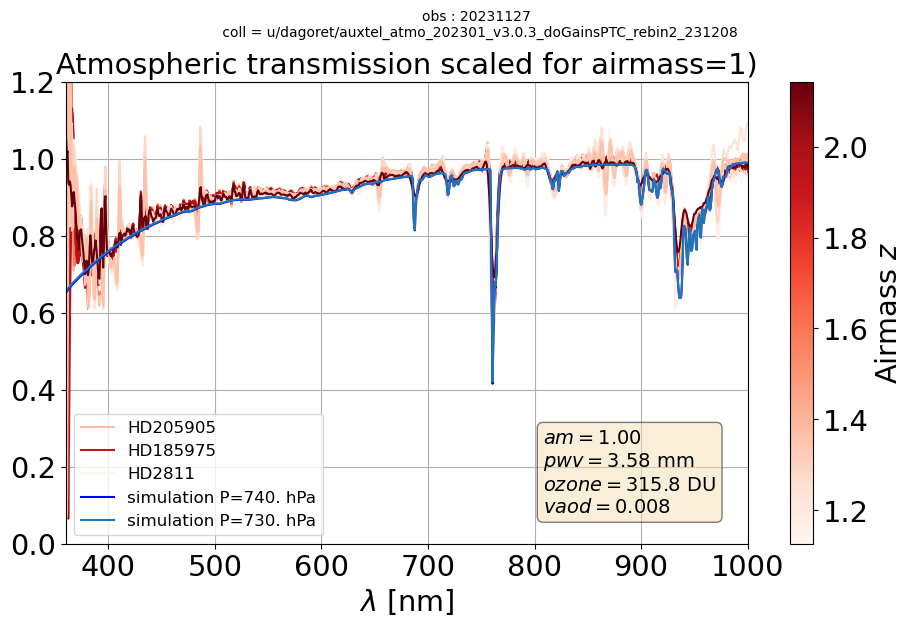

In [49]:
plot_atmtransmission_zcorr_antatmsim(spectra_filtered, [spec.airmass for spec in spectra_filtered],am=1,pwv=pwv0,oz=oz0,vaod=vaod0,grey=grey0)

/tmp/ipykernel_7381/2675659581.py:34: RuntimeWarning: divide by zero encountered in divide
  ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
/tmp/ipykernel_7381/2675659581.py:40: RuntimeWarning: invalid value encountered in power
  sel_ratio_airmas_corr = np.power(sel_ratio,am/spec.airmass)/(np.power(grey,am))
/tmp/ipykernel_7381/2675659581.py:83: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer


AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


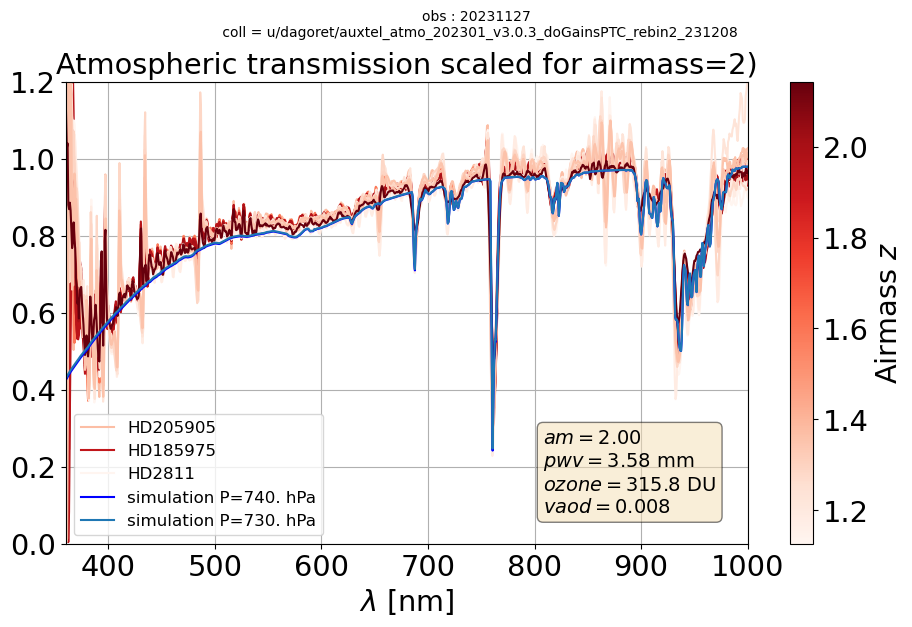

In [50]:
plot_atmtransmission_zcorr_antatmsim(spectra_filtered, [spec.airmass for spec in spectra_filtered],am=2,pwv=pwv0,oz=oz0,vaod=vaod0,grey=grey0)

In [51]:
def plot_atmtransmission_zcorr_antatmsim_ratio(spectra, colorparams,am=1,pwv=2,oz=300,vaod=0.01,grey=0.1):
    """
    plot spectra
    """

    import matplotlib.colors as mcolors
    import matplotlib.cm as cm
    colormap = cm.Reds
    #colormap = cm.jet 
   

    normalize = mcolors.Normalize(vmin=np.min(colorparams), vmax=np.max(colorparams))

    all_shown_target_names = [] 
    
    fig  = plt.figure(figsize=(14,10))

    grid = gridspec.GridSpec(2, 1, height_ratios=[2.5,1])

    ax1 = plt.subplot(grid[0])
    ax2 = plt.subplot(grid[1],sharex=ax1)

    textstr = '\n'.join((
    r'$am=%.2f$' % (am, ),
    r'$pwv=%.2f$ mm' % (pwv, ),
    r'$ozone=%.1f$ DU' % (oz, ),
    r'$vaod=%.3f$' % (vaod,)))
    emul1 =  ObsAtmo("AUXTEL",740.)
    emul2 =  ObsAtmo("AUXTEL",730.)
    


    for spec in spectra:
        
        
        target_name = spec.target.label

        wls = spec.lambdas
        flx = spec.data
        flx_err = spec.err
        
        #c_dict = all_calspecs[target_name]
        c_dict = all_calspecs_sm[target_name]

        #smooth_data_np_convolve(sed,span)
        
        sed=np.interp(wls, c_dict["WAVELENGTH"]/10.,c_dict["FLUX"]*10.,left=1e-15,right=1e-15)
       
                     
        ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
       
        indexes = np.where(np.logical_and(wls>350.,wls<=1000.))[0]
       
        sel_wls = wls[indexes]
        sel_ratio = ratio[indexes]
        sel_ratio_airmas_corr = np.power(sel_ratio,am/spec.airmass)/(np.power(grey,am))
        
        if target_name in all_shown_target_names:
            ax1.plot(sel_wls, sel_ratio_airmas_corr, color = colormap(normalize(spec.airmass)))
        else:
            ax1.plot(sel_wls,sel_ratio_airmas_corr, color = colormap(normalize(spec.airmass)),label=target_name)
            all_shown_target_names.append(target_name)

        transm_sim1 = emul1.GetAllTransparencies(sel_wls,am,pwv,oz,tau=vaod)
        transm_sim2 = emul2.GetAllTransparencies(sel_wls,am,pwv,oz,tau=vaod)
    
        ax1.plot(sel_wls,transm_sim1,'-b')
        ax1.plot(sel_wls,transm_sim2,'-g')

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
   
        # place a text box in upper left in axes coords

        ax2.plot(sel_wls,sel_ratio_airmas_corr/transm_sim1,color = colormap(normalize(spec.airmass)),label=f"simulation P=740. hPa")
        #ax2.plot(sel_wls,sel_ratio_airmas_corr/transm_sim2,'-g',label=f"simulation P=730. hPa")
        ax1.text(0.70, 0.25, textstr, transform=ax1.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    
   
            
    ax1.grid()
    #ax1.set_xlabel("$\lambda$ [nm]")
    #plt.ylabel(f"Flux [{spec.units}]")
    ax1.legend()
    ax1.set_xlim(360.,1000.)  
    ax1.set_ylim(0.,1.2)  

    ax2.set_title(f"ratio spectrum/sim at airmass {am:.2f}")
    ax2.set_xlabel("$\lambda$ [nm]")  
    ax2.set_ylim(0.95,1.05)  
    ax2.grid()
    # Colorbar setup
    s_map = cm.ScalarMappable(norm=normalize, cmap=colormap)
    s_map.set_array(colorparams)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (colorparams[1] - colorparams[0])/2.0
    boundaries = np.linspace(colorparams[0] - halfdist, colorparams[-1] + halfdist, len(colorparams) + 1)

    # Use this to emphasize the discrete color values
    #cbar = fig.colorbar(s_map) #, spacing='proportional', ticks=colorparams, boundaries=boundaries, format='%2.2g') # format='%2i' for integer

    # Use this to show a continuous colorbar
    #cbar = fig.colorbar(s_map, spacing='proportional', ticks=colorparams, format='%2i')
    #cbar.set_label("Airmass $z$")
    title = f"Atmospheric transmission scaled for airmass={am})"
    suptitle = f"obs : {DATEOBS} \n coll = {my_collection}"
    ax1.set_title(title)
    plt.suptitle(suptitle,fontsize=10,y=1.0)

    
    plt.show()
    



AUXTEL site name validated as LSST observatory
AUXTEL site name validated as LSST observatory


/tmp/ipykernel_7381/637992499.py:50: RuntimeWarning: divide by zero encountered in divide
  ratio = flx/tel.transmission(wls)/disp.transmission(wls)/sed
/tmp/ipykernel_7381/637992499.py:56: RuntimeWarning: invalid value encountered in power
  sel_ratio_airmas_corr = np.power(sel_ratio,am/spec.airmass)/(np.power(grey,am))


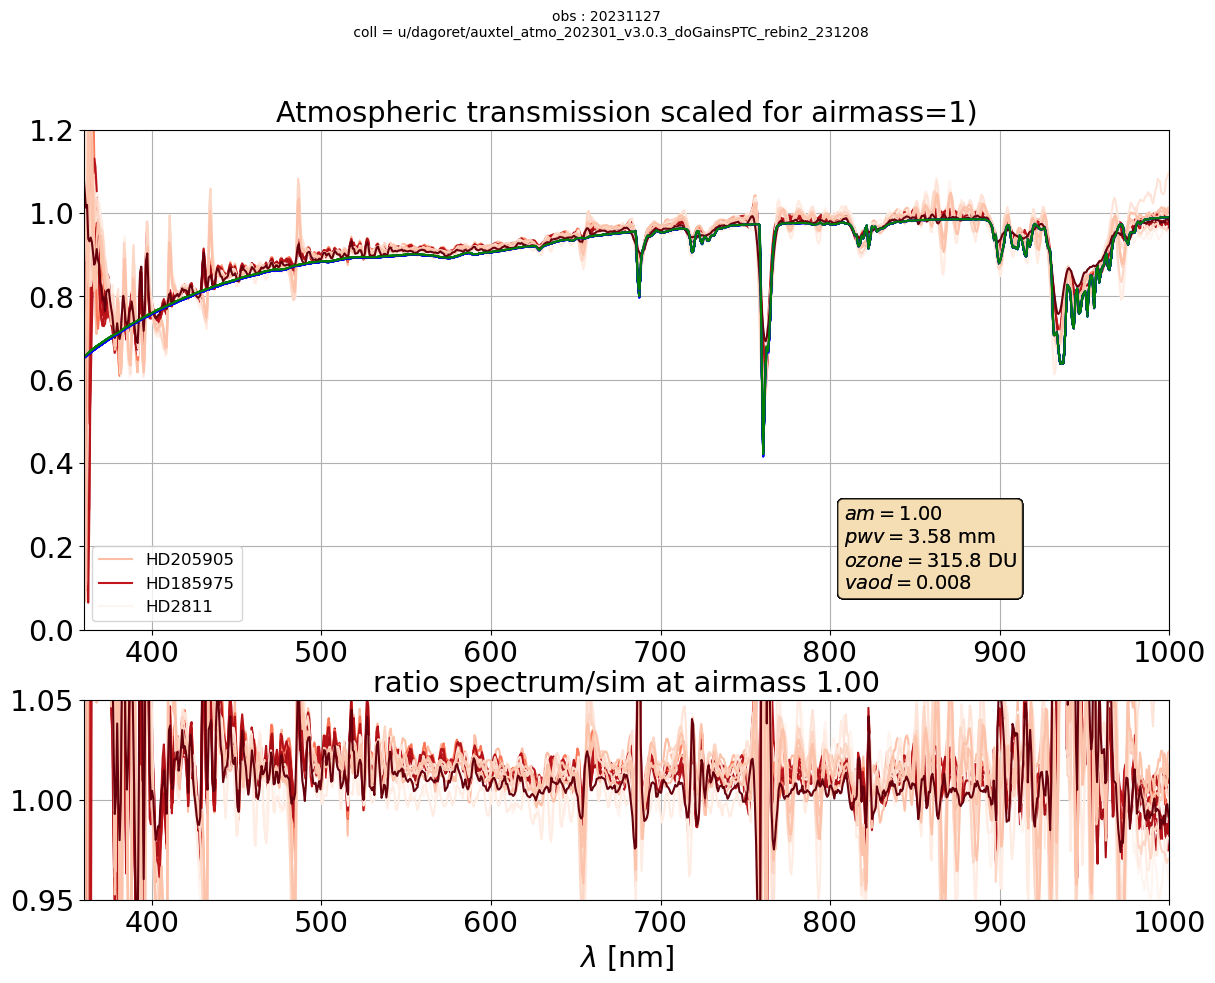

In [52]:
plot_atmtransmission_zcorr_antatmsim_ratio(spectra_filtered, [spec.airmass for spec in spectra_filtered],am=1,pwv=pwv0,oz=oz0,vaod=vaod0,grey=grey0)

## Information from atmospheric fits

In [53]:
columns_spectrum = ["id"]

for h in headers[0]:
    if "COMMENT" in h or "EXTNAME" in h: continue
    if "LBDAS_T" in h or "PSF_P_T" in h or "AMPLIS_T" in h: continue
    if "UNIT" in h: continue
    if "SIMPLE" in h: continue
    columns_spectrum.append(h)
 
columns_spectrogram_bestfit = []
for key in params_spectrogram[0].labels:
    columns_spectrogram_bestfit.append(key)
    columns_spectrogram_bestfit.append(key+"_err")

columns_spectrum_bestfit = []
for key in params_spectrum[0].labels:
    columns_spectrum_bestfit.append(key)
    columns_spectrum_bestfit.append(key+"_err")

In [54]:
min_index = 0
max_index = np.inf

df1 = pd.DataFrame(columns=columns_spectrum)

for k, header in enumerate(headers):
    # if k > 40: break
    n = records[k].id
    if n < min_index or n > max_index: continue
    row = {"id": n}
    for h in header:
        if h in columns_spectrum:
            row[h] = header[h]
    df1.loc[len(df1)] = row
            
df2 = pd.DataFrame(columns=columns_spectrogram_bestfit)

for k, p in enumerate(params_spectrogram):
    n = records[k].id
    if n < min_index or n > max_index: continue
    row = {"id": n}
    for i, key in enumerate(p.labels):
        row[key] = p.values[i]
        row[key+"_err"] = p.err[i]
    df2.loc[len(df2)] = row
            
df3 = pd.DataFrame(columns=columns_spectrum_bestfit)

for k, p in enumerate(params_spectrum):
    n = records[k].id
    if n < min_index or n > max_index: continue
    row = {"id": n}
    for i, key in enumerate(p.labels):
        row[key] = p.values[i]
        row[key+"_err"] = p.err[i]
    df3.loc[len(df3)] = row
            

/home/d/dagoret/repos/repos_w_2023_44/Spectractor/lib/python/spectractor/fit/fitter.py:311: RuntimeWarning: invalid value encountered in sqrt
  err[~np.asarray(self.fixed)] = np.sqrt(np.diag(self.cov))
/home/d/dagoret/repos/repos_w_2023_44/Spectractor/lib/python/spectractor/fit/fitter.py:311: RuntimeWarning: invalid value encountered in sqrt
  err[~np.asarray(self.fixed)] = np.sqrt(np.diag(self.cov))


In [55]:
df = pd.merge(df1, df2, left_index=True, right_index=True)
df = pd.merge(df, df3, left_index=True, right_index=True)
df.set_index('DATE-OBS', inplace=True)
#df.index = pd.to_datetime(df.index, format="ISO8601") #['DATE-OBS'])
df.index = pd.to_datetime(df.index) #['DATE-OBS'])
df.sort_index(inplace=True)

In [56]:
# convert pandas to numpy rec array
rec = df.to_records()

In [57]:
filtered = (rec["CHI2_FIT"] < 100) & (rec["PSF_REG"] > 1e-2) & (rec["D2CCD"] > 186)  & (rec["D2CCD"] < 188)  # & (np.abs(rec["PIXSHIFT"]) < 0.5) 
print(np.sum(filtered))
filtered = filtered & (rec["PWV [mm]_err_x"] > 0) & (rec["PWV [mm]_err_x"] < 5) & (rec["A1_err_y"] > 0) & (rec["A1_err_y"] < 5) & (rec["PWV [mm]_err_y"] > 0) & (rec["PWV [mm]_err_y"] < 5)
print(np.sum(filtered))
filtered = filtered & (rec["reso [pix]"] < 3)
print(np.sum(filtered))
filtered = filtered & (rec["ozone [db]_err_y"] > 0) & (rec["ozone [db]_err_y"] < 100)
print(np.sum(filtered))
filtered = filtered & (rec["A1_x"] > 0.1) & (rec["A1_x"] < 1.5)
print(np.sum(filtered))
filtered = filtered & (np.abs(rec["gamma_0_2"]) < 30) & (np.abs(rec["alpha_0_2"]) < 10)
print(np.sum(filtered))

24
23
23
22
22
21


In [58]:
stars = np.unique(rec["TARGET"])
stars

array(['HD185975', 'HD205905', 'HD2811', 'HD38666'], dtype=object)

In [59]:
filters = np.unique(rec["FILTER"])
filters

array(['empty'], dtype=object)

In [60]:
ATMMINMAX = {}
ATMMINMAX["A1_y"] = [0.7,1.3]
ATMMINMAX["chi2_y"] = [0.,500.]
ATMMINMAX["ozone [db]_y"] = [0.,600.]
ATMMINMAX["PWV [mm]_y"] = [0.,10.]
ATMMINMAX["VAOD_y"] = [0.,0.2]
ATMMINMAX["A2_y"] = [0.7,1.3]

ATMMINMAX["A1_x"] = [0.7,1.3]
ATMMINMAX["chi2_x"] = [0.,500.]
ATMMINMAX["ozone [db]_x"] = [0.,600.]
ATMMINMAX["PWV [mm]_x"] = [0.,10.]
ATMMINMAX["VAOD_x"] = [0.,0.2]
ATMMINMAX["A2_x"] = [0.7,1.3]

## Open Fitted param files

In [61]:
#f_atmparamfitted  = h5py.File(fitted_paramfile, 'a') 
#g = f_atmparamfitted.create_group(str(DATEOBS))

FLAG_KEYS_FOUND = False
FLAG_FITTEDPARAM_FOUND = False
datetag_str = str(DATEOBS)

try:
    with h5py.File(fitted_paramfile, mode='r') as f_atmparamfitted:
        all_keys = list(f_atmparamfitted.keys())
        FLAG_KEYS_FOUND = True
        print("all keys found ",all_keys)

        # read all keys already registered    
        #df_dict = {}
        #for k in all_keys:
        #    if k != datetag_str:
        #        df_dict[k] = pd.read_hdf(f_atmparamfitted, key=k)

        
        f_atmparamfitted.close()
except (KeyError, TypeError, FileNotFoundError):
    FLAG_KEYS_FOUND = False
    f_atmparamfitted.close()



all keys found  ['20231127']


### Overwrite the average fitted parameters

In [62]:
f_atmparamfitted = h5py.File(fitted_paramfile, mode='w')
group_dateobs = f_atmparamfitted.create_group(datetag_str)

In [63]:
group_dateobs

<HDF5 group "/20231127" (0 members)>

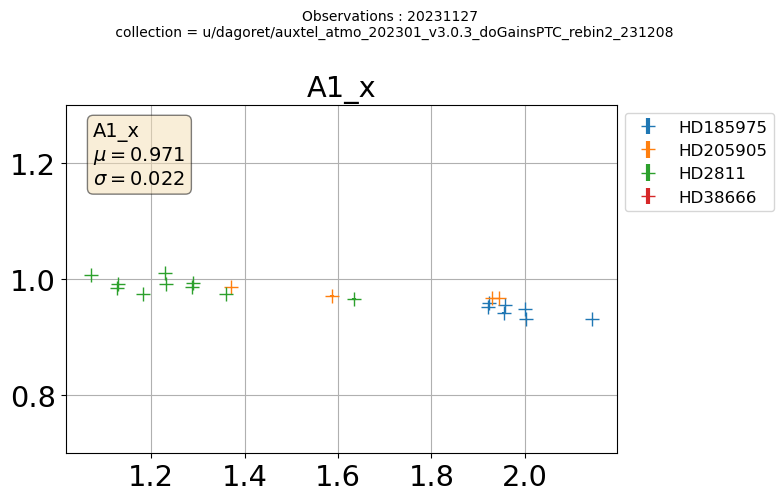

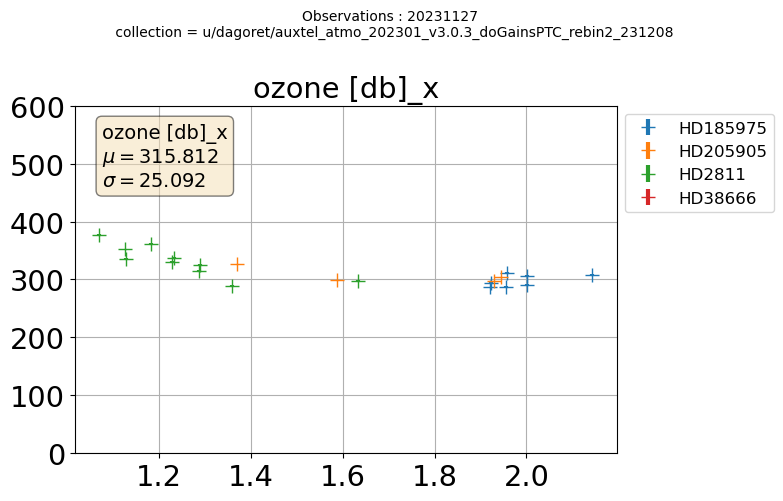

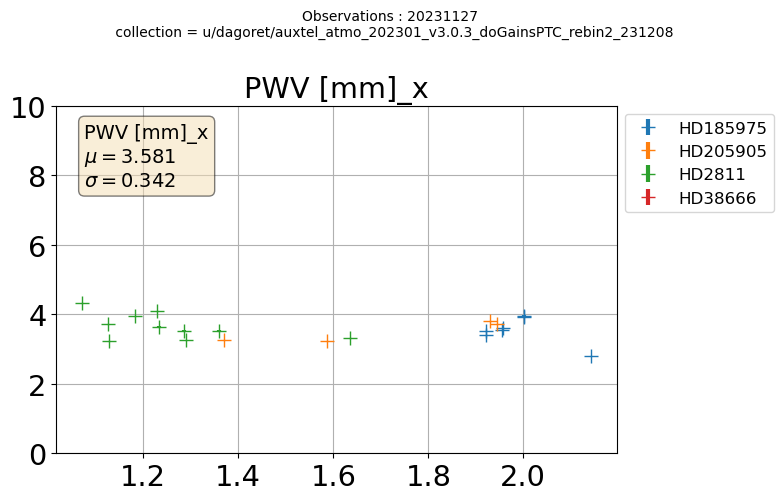

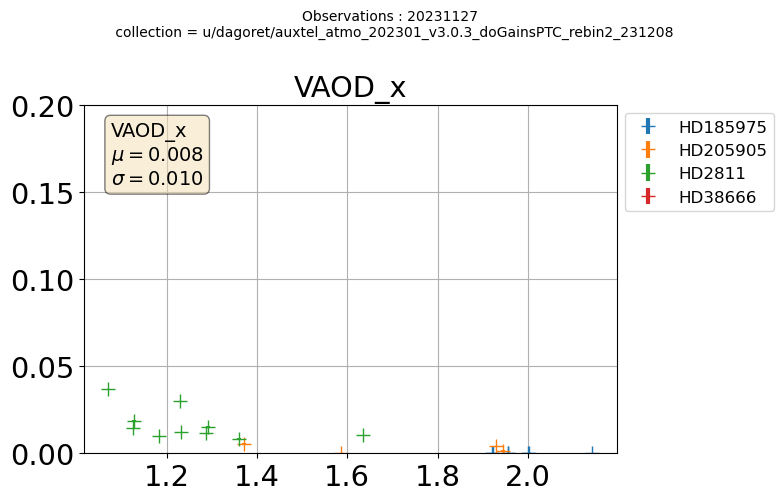

In [64]:
#for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x", "D_CCD [mm]_x", "gamma_0_1", "gamma_0_2", "alpha_0_1", "alpha_0_2", "y_c_0_1", "y_c_0_2" ]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"
    fig = plt.figure(figsize=(8,5))

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    # save the average on the attribute
    group_dateobs.attrs[col] = mu

    for star in stars:
        index = filtered & (rec["TARGET"] == star) & (rec["FILTER"]=="empty")
        if col_err in df.columns:
            plt.errorbar(rec["AIRMASS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=10,lw=3 ,label=star)
        else:
            plt.plot(rec["AIRMASS"][index], rec[col][index], linestyle="none", marker="+",ms=10,lw=3 )
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    #plt.gcf().autofmt_xdate()
    suptitle = f"Observations : {DATEOBS} \n collection = {my_collection}"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()
f_atmparamfitted.close()

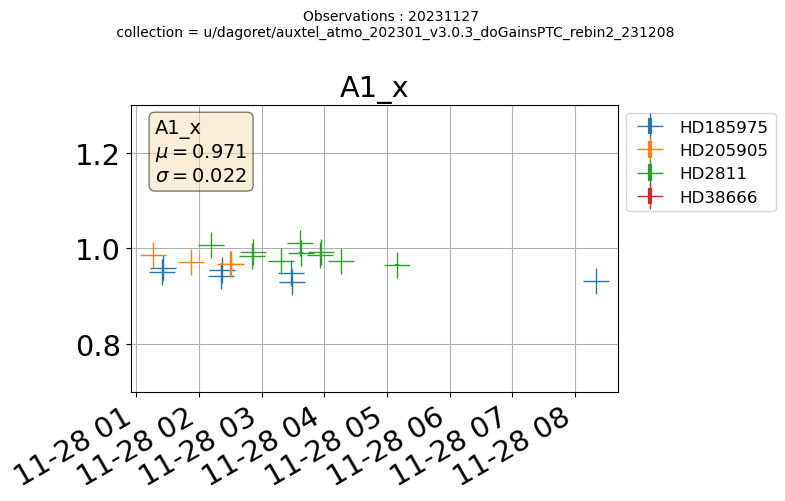

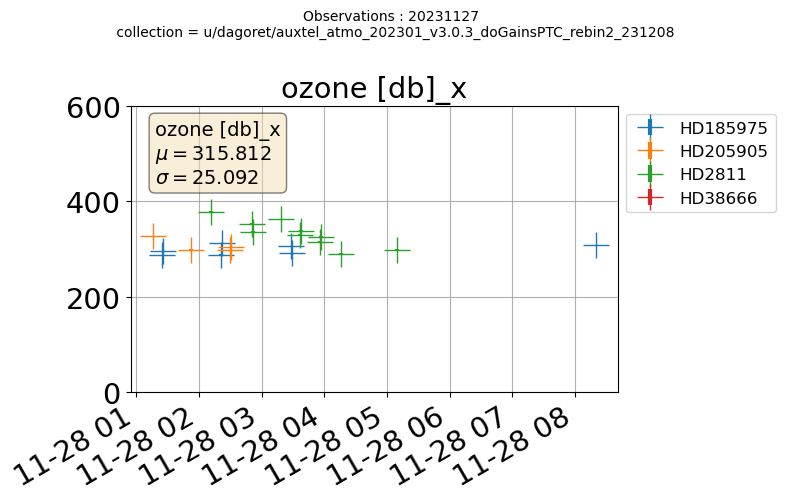

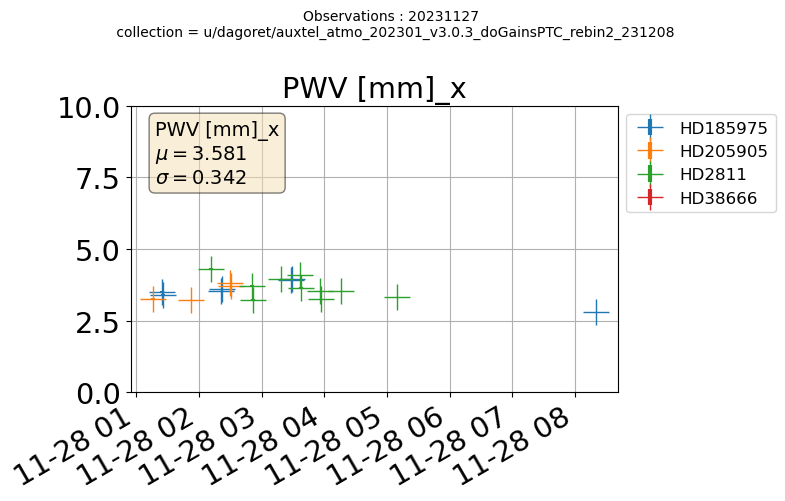

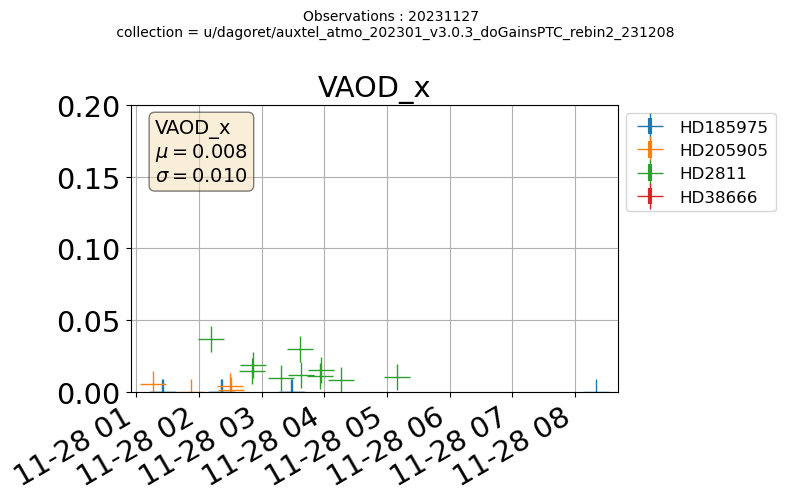

In [65]:
for col in ["A1_x", "ozone [db]_x", "PWV [mm]_x", "VAOD_x"]:
    if len(col.split('_')) > 1:
        col_err = '_'.join(col.split('_')[:-1])+"_err_"+col.split('_')[-1]
    else:
        col_err = col+"_err"

    index = filtered  & (rec["FILTER"]=="empty")
    all_values = rec[col][index]
    mu = all_values.mean()
    sig =all_values.std()
    textstr = '\n'.join((col,
    r'$\mu=%.3f$' % (mu, ),
    r'$\sigma=%.3f$' % (sig, )))

    fig = plt.figure(figsize=(8,5))
    for star in stars:
        index = filtered & (rec["TARGET"] == star)
        if col_err in df.columns:
            plt.errorbar(rec["DATE-OBS"][index], rec[col][index], yerr=rec[col_err][index], linestyle="none", marker="+",ms=19,lw=3 ,label=star)
        else:
            plt.plot(rec["DATE-OBS"][index], rec[col][index], linestyle="none", marker="+",ms=10,lw=3)
    plt.ylim((0.9*np.min(rec[col][filtered]), 1.1*np.max(rec[col][filtered])))
    if col in list(ATMMINMAX.keys()):
        plt.ylim(ATMMINMAX[col][0],ATMMINMAX[col][1])

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax = plt.gca()
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)


    plt.grid()
    plt.title(col)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.gcf().autofmt_xdate()
    suptitle = f"Observations : {DATEOBS} \n collection = {my_collection}"
    plt.suptitle(suptitle,fontsize=10,y=1.0)
    plt.tight_layout()
    plt.show()